# LIGO - Gravitational Waves Detectability

### What am I looking for?
1. High interpretability $\to$ no PCA (there is physics behind features!)
2. Feature importance - *which variables matter most for disciminating signals in detectable and non detectable ones?*
3. Boundary - *Where does the boundary between classes stand?*
5. TPR --> *how likely is it using this model to classify a detectable signal as such?*
6. FPR --> *how likely is it using this model to classify a non-detectable signal as a detectable one?*
7. TNR --> *how likely is it using this model to classify a non-detectable signal as a such?*
8. FNR --> *how likely is it using this model to classify a detectable signal as a non-detectable one?*

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import sys
sys.path.append(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks")
from Utilities import plot_settings

Load downsampled data

In [2]:
y = np.load(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks\Exam\LIGO\Npy\y_ds_100k.npy")

In [3]:
data = np.load(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks\Exam\LIGO\Npy\data_ds_100k.npy")

In [4]:
keys = np.load(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks\Exam\LIGO\Npy\keys.npy")

Preprocess data : split for training and validation $\oplus$ standardization

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
S_train = StandardScaler().fit_transform(X_train)
S_test  = StandardScaler().fit_transform(X_test)

Train the classifier

In [43]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score

Try with random hyperparameters

In [27]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.utils import resample

X_sub, y_sub = resample(S_train, y_train, n_samples=20000, random_state=42, stratify=y_train)

custom_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Base model
model = LinearSVC(
    penalty='l1',
    loss='squared_hinge',
    dual=False,
    max_iter=1000,
    random_state=42
)

# Hyperparameter grid to search
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],         # Regularization strengths
    'tol': [1e-3, 1e-4],            # Stopping tolerance
    'class_weight': [None, 'balanced']    # Handle class imbalance
}

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',  # Or another metric like 'f1', 'roc_auc' if preferred
    cv=custom_cv,
    n_jobs=-1,           # Use all CPU cores
    verbose=2,
    refit=True           # Refit best model on the whole data after search
)

In [28]:
grid_search.fit(S_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=LinearSVC(dual=False, penalty='l1', random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'class_weight': [None, 'balanced'],
                         'tol': [0.001, 0.0001]},
             scoring='roc_auc', verbose=2)

In [29]:
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'C': 0.01, 'class_weight': None, 'tol': 0.0001}
Best score: 0.976657375449831


In [34]:
clf = grid_search.best_estimator_

LinearSVC(C=0.01, dual=False, penalty='l1', random_state=42)

In [35]:
def completeness_contamination(y_true, y_pred, positive_label=1):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, positive_label]).ravel()
    
    completeness = tp / (tp + fn) if (tp + fn) else 0
    contamination = fp / (tp + fp) if (tp + fp) else 0
    TNR = tn / (tn + fp) if (tn + fp) else 0
    
    return completeness, contamination, TNR

In [37]:
completeness, contamination, TNR = completeness_contamination(y_test, clf.predict(S_test))

In [38]:
print(f'completeness  : {completeness:.2}')
print(f'contamination : {contamination:.2}')
print(f'TNR           : {TNR:.2}')

completeness  : 0.79
contamination : 0.2
TNR           : 0.97


Completeness is descretely high and contamination is more then decently low, good news!\
This means that:
1. Of the "really detectable" signals, the model missed $21\%$ of the true positives $\to$ of a 1000 true positives, I'll miss 150 
2. Of the signals identified as detectables, $20\%$ are in reality non detectable (contaminants)
3. Of the signals identified as non detectables, $97\%$ are really non detectables signals

In [40]:
y_pred = clf.predict(S_test)

In [45]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Accuracy score:", accuracy_score(y_test, y_pred))

[[16472   592]
 [  623  2313]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     17064
           1       0.80      0.79      0.79      2936

    accuracy                           0.94     20000
   macro avg       0.88      0.88      0.88     20000
weighted avg       0.94      0.94      0.94     20000

Accuracy score: 0.93925


Accuracy of $93\%$ is high! I've answered to points 4-5-6-7

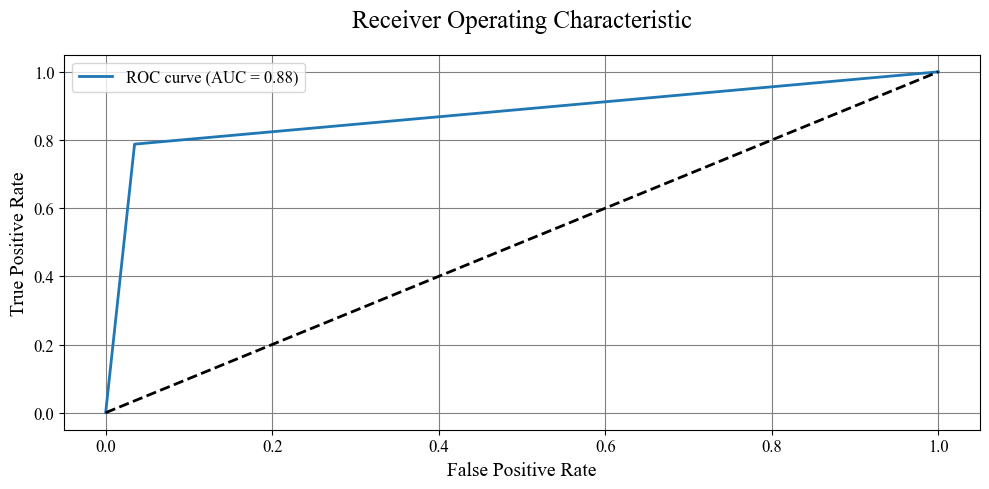

In [46]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_score(y_test, y_pred):.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend()
plt.grid(True)
plt.show()

To answer to point 2 about feature importance, I'll look at the *importance* of features.\
Namely, the average on the number of decision trees of the impurity decreases coused by the splits

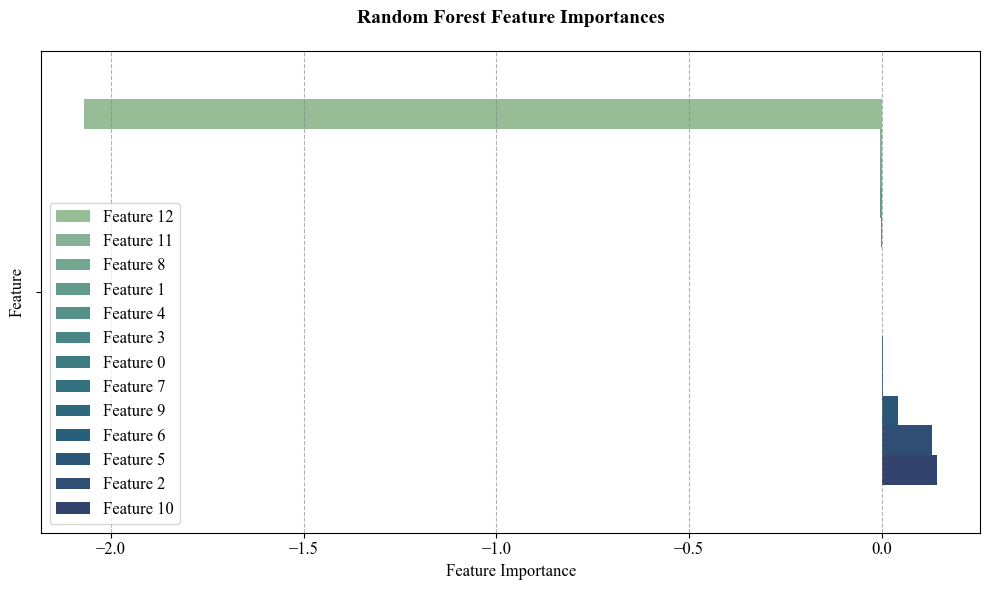

In [48]:
# Example: Replace with your actual values
importances = clf.coef_[0]
feature_names = [f"Feature {i}" for i in range(len(importances))]

# Sort by importance
sorted_idx = np.argsort(importances)
sorted_importances = importances[sorted_idx]
sorted_names = [feature_names[i] for i in sorted_idx]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_importances, hue=sorted_names, palette="crest")

plt.xlabel("Feature Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title("Random Forest Feature Importances", fontsize=14, weight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Looks like feature number $12$ is **extremely important**! This feature is $z$ i.e. **redshift**!\
Let's confirm this computing correlation between labels and features.

In [49]:
# Quick correlation check
import pandas as pd
df = pd.DataFrame(data, columns=[f"Feature {i}" for i in range(data.shape[1])])
df["Label"] = y
print(df.corr()["Label"].sort_values(ascending=False))

Label         1.000000
Feature 10    0.055813
Feature 2     0.051166
Feature 5     0.012977
Feature 0     0.004043
Feature 3     0.002559
Feature 7     0.002090
Feature 6     0.001588
Feature 9    -0.000936
Feature 4    -0.001998
Feature 11   -0.002303
Feature 1    -0.003520
Feature 8    -0.005061
Feature 12   -0.580357
Name: Label, dtype: float64


Ok, feature 12 is negatively correlated to the labels! This means that as redshift increases detectability lowers...it makes perfect sense for the classifier to say it's more probable for GWs signals to be detected if they are not very far away!\
This also means that this feature is THE feature to use for discrimination between det and non-det signals.

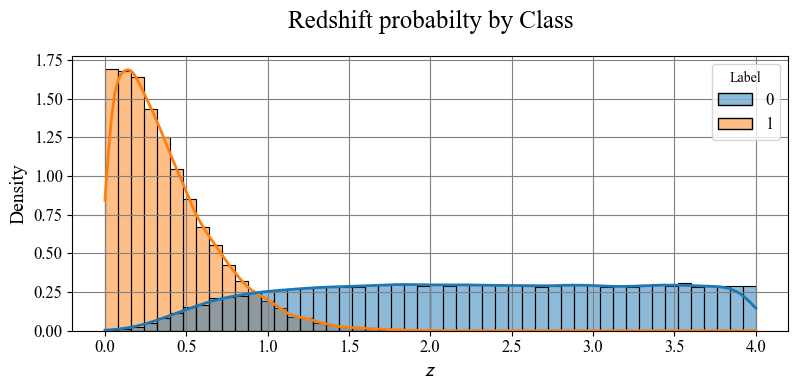

In [50]:
plt.figure(figsize=(8, 4))
sns.histplot(data=df, x='Feature 12', hue="Label", bins=50, kde=True, stat="density", common_norm=False)
plt.title("Redshift probabilty by Class")
plt.xlabel(r"$\mathcal{z}$")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()